Notebook to preprocess/cluster **[GEO dataset](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE167880)**, 
"Functional, metabolic and transcriptional maturation of human pancreatic islets derived from stem cells"   
[Paper](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC9287162/)

Datasets: 
- **GSM5114459**: Stage 5 in vitro (DT)
- **GSM5114469**: Month 1 in vivo (A7)
- **GSM5114476**: Month 6 in vivo (STZ)

In [1]:
import sys
import os
sys.path.append(os.environ["HOME"]+"/.local/lib/python3.9/site-packages")
import scanpy as sc, anndata as ad
import harmonypy
import leidenalg
# diSNE packages
import numpy as np
import pandas as pd
from scipy.sparse import issparse
import matplotlib.pyplot as plt
import seaborn as sns
import hdf5plugin
from scipy.spatial.distance import pdist, squareform

In [10]:
# import diSNE
import diSNE

In [11]:
%%bash
export PATH=$PATH:/home/$USER/.local/bin

In [2]:
sc.logging.print_versions()

-----
anndata     0.9.1
scanpy      1.9.3
-----
PIL                 8.3.1
anyio               NA
attr                21.2.0
babel               2.9.1
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
bottleneck          1.3.2
brotli              NA
certifi             2022.12.07
cffi                1.14.6
chardet             4.0.0
charset_normalizer  2.0.0
cloudpickle         1.6.0
colorama            0.4.6
cycler              0.10.0
cython_runtime      NA
cytoolz             0.11.0
dask                2021.06.2
dateutil            2.8.2
debugpy             1.6.7
decorator           5.0.9
defusedxml          0.7.1
entrypoints         0.3
fastjsonschema      NA
fsspec              2021.07.0
google              NA
h5py                3.3.0
harmonypy           NA
hdf5plugin          4.4.0
idna                3.1
igraph              0.11.4
ipykernel           6.17.1
ipython_genutils    0.2.0
ipywidgets          7.6.3
jedi                0.18.0
jinja2              3.0.

In [4]:
# concatenate all three datasets into single anndata object
DATADIR=os.environ["HOME"]+"/diSNE/tests/test_datasets" #defining dir path
dsets = ["GSM5114459_S5_DT", "GSM5114469_M1_A7", "GSM5114476_M6_STZ"]
adatas = {}
for ds in dsets:
    print(ds)
    adatas[ds] = sc.read_10x_mtx(DATADIR, prefix=ds+"_", cache=True)
combined = ad.concat(adatas, label="dataset")
combined.obs_names_make_unique()

GSM5114459_S5_DT
GSM5114469_M1_A7
GSM5114476_M6_STZ


/opt/conda/lib/python3.9/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [12]:
combined

AnnData object with n_obs × n_vars = 6237 × 15644
    obs: 'dataset', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [5]:
combined.obs

,dataset
AAACCTGAGACGCAAC,GSM5114459_S5_DT
AAACCTGCAGACGCCT,GSM5114459_S5_DT
AAACGGGAGCCACGCT,GSM5114459_S5_DT
AAACGGGAGTTAGCGG,GSM5114459_S5_DT
AAACGGGCAGCGATCC,GSM5114459_S5_DT
...,...
TTTGTTGAGGCCACCT,GSM5114476_M6_STZ
TTTGTTGCAAGCTACT,GSM5114476_M6_STZ
TTTGTTGGTAGGCAAC,GSM5114476_M6_STZ
TTTGTTGGTATGAAAC,GSM5114476_M6_STZ


In [6]:
# filter low expression/counts
# filter cells that have less than 200 genes expressed
sc.pp.filter_cells(combined, min_genes=200)

# filter cells with less than 1000 total reads 
sc.pp.filter_cells(combined, min_counts=1000)

# filter genes that are detected in less than 5 cells
sc.pp.filter_genes(combined, min_cells=5)

# genes that have a total count of less than 15
sc.pp.filter_genes(combined, min_counts=15)

In [7]:
# filter high mitochondria
# compute percent of counts in each cell that are from mitochondrial genes
# annotate the group of mitochondrial genes as "mt"
combined.var["mt"] = combined.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    combined, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

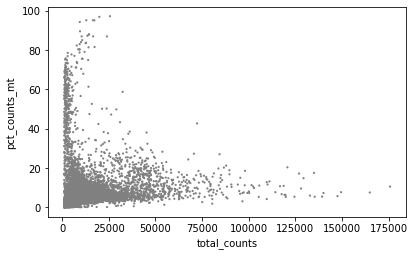

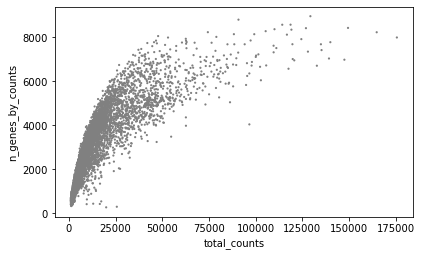

In [8]:
sc.pl.scatter(combined, x="total_counts", y="pct_counts_mt")
sc.pl.scatter(combined, x="total_counts", y="n_genes_by_counts")

In [64]:
# filter cells with high percentage of counts from mitochondrial genes
# 25% as threshold
adata_filt = combined[combined.obs.n_genes_by_counts<7500, :]
adata_filt = adata_filt[adata_filt.obs.pct_counts_mt<25, :].copy() 

In [65]:
adata_filt

AnnData object with n_obs × n_vars = 5750 × 15644
    obs: 'dataset', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

In [66]:
# normalize counts
# total-count normalize data matrix to 10,000 reads per cell
sc.pp.normalize_per_cell(adata_filt, counts_per_cell_after=1e4)

In [67]:
# log transform data
sc.pp.log1p(adata_filt)

In [68]:
# identify highly variable genes
# options: 
# batch_key="dataset" <- select highly variable genes separately within the 3 datasets
# n_top_genes=500 <- select only the top 500 most variable genes
sc.pp.highly_variable_genes(adata_filt, batch_key="dataset", n_top_genes=500)

In [69]:
# create new AnnData object for analyses with:
# only highly variable genes
# genes with specific marker genes from paper (manually add back even if not most differentially expressed)
genes = ["GCG", "TTR",  "IAPP",  "GHRL", "PPY", "COL3A1",
    "CPA1", "CLPS", "REG1A", "CTRB1", "CTRB2", "PRSS2", "CPA2", "KRT19", "INS","SST","CELA3A", "VTCN1"]

adata_var = adata_filt[:, (adata_filt.var.index.isin(genes) | adata_filt.var["highly_variable"])]

In [71]:
# visualize batch effects
# perform PCA on dataset and plot data along the first 2 PCs
# compute first 20 PCs
sc.pp.pca(adata_var, n_comps=20)

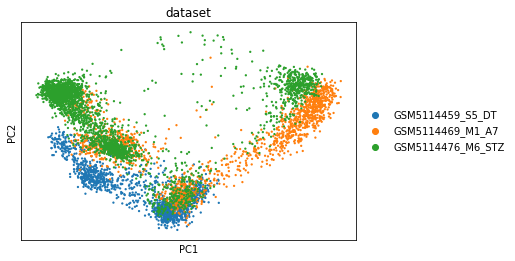

In [72]:
# plot data, color cells based on dataset they came from
sc.pl.pca(adata_var, color="dataset")

In [73]:
# adjust count data to control for batch effects
# use Harmony from within scanpy
# Import the "external" library
import scanpy.external as sce

# Run harmony using suggested params from the paper
sce.pp.harmony_integrate(adata_var, 'dataset', theta=2, nclust=50,  max_iter_harmony = 10,  max_iter_kmeans=10)

# Reset the original PCs to those computed by Harmony
adata_var.obsm['X_pca'] = adata_var.obsm['X_pca_harmony']

2024-05-30 20:37:13,235 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
Computing initial centroids with sklearn.KMeans...
2024-05-30 20:37:16,477 - harmonypy - INFO - sklearn.KMeans initialization complete.
sklearn.KMeans initialization complete.
2024-05-30 20:37:16,567 - harmonypy - INFO - Iteration 1 of 10
Iteration 1 of 10
2024-05-30 20:37:19,159 - harmonypy - INFO - Iteration 2 of 10
Iteration 2 of 10
2024-05-30 20:37:21,669 - harmonypy - INFO - Iteration 3 of 10
Iteration 3 of 10
2024-05-30 20:37:24,358 - harmonypy - INFO - Iteration 4 of 10
Iteration 4 of 10
2024-05-30 20:37:26,957 - harmonypy - INFO - Iteration 5 of 10
Iteration 5 of 10
2024-05-30 20:37:29,462 - harmonypy - INFO - Iteration 6 of 10
Iteration 6 of 10
2024-05-30 20:37:32,658 - harmonypy - INFO - Iteration 7 of 10
Iteration 7 of 10
2024-05-30 20:37:35,569 - harmonypy - INFO - Converged after 7 iterations
Converged after 7 iterations


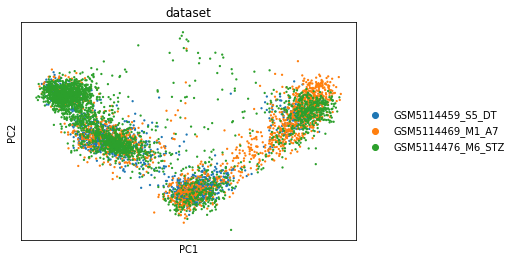

In [35]:
# make new PCA plot on adjusted PCs, should see batch effects somewhat corrected
sc.pl.pca(adata_var, color="dataset")

In [43]:
#sc.pp.subsample(adata_var,n_obs=500)

In [75]:
adata_var

AnnData object with n_obs × n_vars = 5750 × 508
    obs: 'dataset', 'n_genes', 'n_counts', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'dataset_colors'
    obsm: 'X_pca', 'X_pca_harmony'
    varm: 'PCs'

In [76]:
# identify individual cell types/visualize results
# perform clustering using scanpy
# computes neighborhood graphs. Needed to run clustering.
sc.pp.neighbors(adata_var) 

In [77]:
# clusters cells based on expression profiles. This is needed to color cells by cluster.
sc.tl.leiden(adata_var) 

In [48]:
# export filtered dataset as h5ad to test diSNE on
compression = hdf5plugin.FILTERS["zstd"]
compression_opts = hdf5plugin.Zstd(clevel=5).filter_options
adata_var.write_h5ad('GEO_subsample', compression=compression, compression_opts=compression_opts)

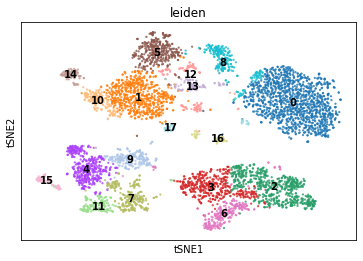

In [78]:
# SCANPY t-SNE VISUALIZATION
# visualize using tSNE
# can change color to color cells by different attributes
# "leiden" = by cluster assignment
sc.tl.tsne(adata_var)
sc.pl.tsne(adata_var, color=['leiden'], legend_loc='on data', legend_fontsize=10, alpha=0.8, size=20)

In [49]:
# STEP 2b
# perform grid search to obtain values of sigma based on perplexity (used to get similarities)
def search_sigma(distances, curr, perplexity):
    """
    Obtain σ's based on user's perplexity value.

    Parameters:
        distances (np.ndarray): Array containing the pairwise distances between data points.
        curr (int): Index of current data point.
        perplexity (int): User-specified perplexity value.

    Returns:
        sig (float): The value of σ that satisfies the perplexity condition.
    """
    result = np.inf  # Set first result to be infinity

    norm = np.linalg.norm(distances, axis=1)
    std_norm = np.std(norm)  # Use standard deviation of norms to define search space

    for sig_search in np.linspace(0.01 * std_norm, 5 * std_norm, 200):
        # Equation 1 Numerator
        p = np.exp(-(norm**2) / (2 * sig_search**2))

        # Set p = 0 when i = j
        p[curr] = 0

        # Equation 1 (ε -> 0)
        ε = np.nextafter(0, 1)
        p_new = np.maximum(p / np.sum(p), ε)

        # Handle potential NaNs
        if np.any(np.isnan(p_new)):
           # print(f"Skipping sig_search {sig_search}: p_new contains NaNs")
            continue

        # Shannon Entropy
        p_new = p_new[p_new > 0]  # Avoid log2(0) by filtering out non-positive values
        if len(p_new) == 0:  # Check if p_new is empty after filtering
           # print(f"Skipping sig_search {sig_search}: p_new is empty after filtering")
            continue

        H = -np.sum(p_new * np.log2(p_new))

        # Handle potential NaN in H
        if np.isnan(H):
          #  print(f"Skipping sig_search {sig_search}: H is NaN, p_new: {p_new}")
            continue

        # Get log(perplexity equation) as close to equality
        if np.abs(np.log(perplexity) - H * np.log(2)) < np.abs(result):
            result = np.log(perplexity) - H * np.log(2)
            sig = sig_search

    return sig

In [50]:
# STEP 2a
# compute affinities matrix for X in the original (high-dimensional) space
def get_highdim_affinities(X, perplexity):
    """
    Function to obtain similarities matrix in original high-dimensional space.

    Parameters:
    X (??): Input dataset
    perplexity (int): Perplexity of the joint probability distribution

    Returns:
    P (np.ndarray of shape (number of samples * (num samples - 1) / 2)): Joint probabilities  matrix.
    """ 
    n = len(X)
    #print(n)
    P = np.zeros((n, n))
    
    for i in range(0, n):
        # equation 1 numerator
        difference = X[i] - X
        #print(difference.shape)
        sig_i = search_sigma(difference, i, perplexity) # call search function to get sigma
        norm = np.linalg.norm(difference, axis=1)
        P[i, :] = np.exp(-(norm**2) / (2 * sig_i**2))

        # Set p = 0 when j = i
        np.fill_diagonal(P, 0)

        # compute equation 1
        P[i, :] = P[i, :] / np.sum(P[i, :])

    # Set 0 values to minimum numpy value (ε approx. = 0)
    eps = np.nextafter(0, 1)
    P = np.maximum(P, eps)

#     print("Completed Pairwise Affinities Matrix. \n")

    return P

In [51]:
# STEP 2c
# convert original affinities matrix into joint probabilities (symmetric) affinities matrix
def convert_to_jointprob(P):
    """
    Obtain symmetric affinities matrix from original affinities matrix to be utilized in t-SNE.

    Parameters:
    P (np.ndarray): Input (original) affinity matrix.

    Returns:
    P_symmetric (np.ndarray): Symmetric affinities matrix.

    """
    n = len(P)
    P_symmetric = np.zeros(shape=(n, n))
    for i in range(0, n):
        for j in range(0, n):
            P_symmetric[i, j] = (P[i, j] + P[j, i]) / (2 * n)

    # Set 0 values to minimum numpy value (ε approx. = 0)
    eps = np.nextafter(0, 1)
    P_symmetric = np.maximum(P_symmetric, eps)

    return P_symmetric

In [52]:
# STEP 3a
# sample initial solution in lower-dimensional space
def initialize(X, n_dim: int = 2, initialization: str = "random"):
    """
    Create initial solution for t-SNE either randomly or using PCA.

    Parameters:
        X (np.ndarray): The input data array.
        n_dimensions (int): The number of dimensions for the output solution. Default is 2.
        initialization (str): The initialization method. Can be 'random' or 'PCA'. Default is 'random'.

    Returns:
        soln (np.ndarray): The initial solution for t-SNE.

    Raises:
        ValueError: If the initialization method is neither 'random' nor 'PCA'.
    """

    # sample initial solution 
    if initialization == "random" or initialization != "PCA":
        soln = np.random.normal(loc=0, scale=1e-4, size=(len(X), n_dim))
    elif initialization == "PCA":
        X_centered = X - X.mean(axis=0)
        _, _, Vt = np.linalg.svd(X_centered)
        soln = X_centered @ Vt.T[:, :n_dimensions]
    else:
        raise ValueError("Initialization must be 'random' or 'PCA'")

    return soln

In [53]:
# STEP 3b
# compute affinity matrix in lower-dimensional space
# use a Student t-distribution with 1 df
def get_lowdim_affinities(Y):
    """
    Obtain low-dimensional affinities.

    Parameters:
    Y (np.ndarray): Low-dimensional representation of the data points.

    Returns:
    Q (np.ndarray): The low-dimensional affinities matrix.
    """

    n = len(Y)
    Q = np.zeros(shape=(n, n))

    for i in range(0, n):
        # equation 4 numerator
        difference = Y[i] - Y
        norm = np.linalg.norm(difference, axis=1)
        Q[i, :] = (1 + norm**2) ** (-1)

    # Set p = 0 when j = i
    np.fill_diagonal(Q, 0)

    # equation 4
    Q = Q / Q.sum()

    # Set 0 values to minimum numpy value (ε approx. = 0)
    eps = np.nextafter(0, 1)
    Q = np.maximum(Q, eps)

    return Q

In [54]:
# STEP 4
# compute gradient of the cost function 
# cost function = Kullback-Leibler divergence btwn joint prob distrs in 
# high dimensional space vs low dimensional space
def compute_gradient(P, Q, Y):
    """
    Obtain gradient of cost function at current point Y.

    Parameters:
    P (np.ndarray): The joint probability distribution matrix.
    Q (np.ndarray): The Student's t-distribution matrix.
    Y (np.ndarray): The current point in the low-dimensional space.

    Returns:
    gradient (np.ndarray): The gradient of the cost function at the current point Y.
    """

    n = len(P)

    # Compute gradient
    gradient = np.zeros(shape=(n, Y.shape[1]))
    for i in range(0, n):
        difference = Y[i] - Y
        A = np.array([(P[i, :] - Q[i, :])])
        B = np.array([(1 + np.linalg.norm(difference, axis=1)) ** (-1)])
        C = difference
        gradient[i] = 4 * np.sum((A * B).T * C, axis=0)

    return gradient

In [61]:
def diSNE(adata, perplexity, T, learning_rate, early_exaggeration, pca=False):
    """
    t-SNE (t-Distributed Stochastic Neighbor Embedding) algorithm implementation.
    Using the results from the helper functions defined in diSNE_utils.py, this function iterates 
    and optimizes low-dimensional mapping, using a gradient descent with momentum.

    Args:
        adata (file containing AnnData object): Input file containing the AnnData object representing the user's dataset.
        perplexity (int, optional): Perplexity parameter. Default is 10.
        T (int, optional): Number of iterations for optimization. Default is 1000.
        learning_rate (int, optional): Learning rate for updating the low-dimensional embeddings, or controlling
        the step size at each iteration. Default is 200.
        early_exaggeration (int, optional): Factor by which the pairwise affinities are exaggerated
            during the early iterations of optimization. Default is 4.
        n_dim (int, optional): The number of dimensions of the low-dimensional embeddings. Default is 2.
        pca (bool, optional): Whether or not PCA has been run on the dataset, speeds up t-SNE

    Returns:
        adata_diSNE (file containing AnnData object): File containing new AnnData object containing the t-SNE results.

    """
    n_dim = 2
    if perplexity is None: 
        perplexity = 10
    if T is None:
        T = 1000
    if learning_rate is None:
        learning_rate = 200
    if early_exaggeration is None:
        early_exaggeration = 4
#     if pca is None:
#         learning_rate = 200
#     print("perplex:", perplexity)
#     print("T:", T)
#     print("learning rate:", learning_rate)
#     print("early exag:", early_exaggeration)
#     print("dim:", n_dim)
#     print("pca:", pca)
        
    # read in user's file as an AnnData object
#     dataset = ad.read_h5ad(adata)
    
#     if pca: # set matrix to PCA if user specified PCA option
    X = adata.obsm['X_pca']
#     else:
#         X = dataset.X
    n = len(X)

    # Get original affinities matrix
    P = get_highdim_affinities(X, perplexity)
    P_symmetric = convert_to_jointprob(P)

    # Initialization
    Y = np.zeros(shape=(T, n, n_dim))
    Y_minus1 = np.zeros(shape=(n, n_dim))
    Y[0] = Y_minus1
    Y1 = initialize(X, n_dim)
    Y[1] = np.array(Y1)

    print("Optimizing Low Dimensional Embedding....")
    # Optimization of the low-dimensional embedding
    for t in range(1, T - 1):
        # Momentum & Early Exaggeration
        if t < 250:
            momentum = 0.5
            early_exaggeration = early_exaggeration
        else:
            momentum = 0.8
            early_exaggeration = 1

        # Get Low Dimensional Affinities
        Q = get_lowdim_affinities(Y[t])

        # Get Gradient of Cost Function
        gradient = compute_gradient(early_exaggeration * P_symmetric, Q, Y[t])

        # Update Rule
        Y[t + 1] = Y[t] - learning_rate * gradient + momentum * (Y[t] - Y[t - 1])  # Use negative gradient

        # Compute current value of cost function (Kullback-Leibler divergence)
        if t % 100 == 0:
            cost = np.sum(P_symmetric * np.log(P_symmetric / Q))
            print(f"Iteration {t} of {T}: Value of Cost Function is {cost}")

    print(
        f"Completed Low Dimensional Embedding: Final Value of Cost Function is {np.sum(P_symmetric * np.log(P_symmetric / Q))}"
    )   
    soln = Y[-1]

#     return soln, Y
    adata.obsm['X_tsne'] = soln
    return

In [57]:
# plot t-SNE results 
def plot_tsne_results(adata, feature, title='diSNE results', figsize=(10, 8)):
    tsne_out = adata.obsm['X_tsne']
    labels = adata.obs[feature].astype(int).values
    plt.figure(figsize=figsize)
    scatter = plt.scatter(tsne_out[:, 0], tsne_out[:, 1], c=labels, cmap='viridis', marker='o')
    if labels is not None:
        plt.legend(*scatter.legend_elements(), title="Clusters")
    plt.title(title)
    plt.xlabel('t-SNE 1')
    plt.ylabel('t-SNE 2')
#     plt.colorbar()
    plt.show()

In [ ]:
diSNE(adata_var, 30, 1000, 1000, 12, 2)

/tmp/ipykernel_132/1527008661.py:29: RuntimeWarning: invalid value encountered in true_divide
  p_new = np.maximum(p / np.sum(p), ε)


Optimizing Low Dimensional Embedding....
Iteration 100 of 1000: Value of Cost Function is 4.3562110380534405


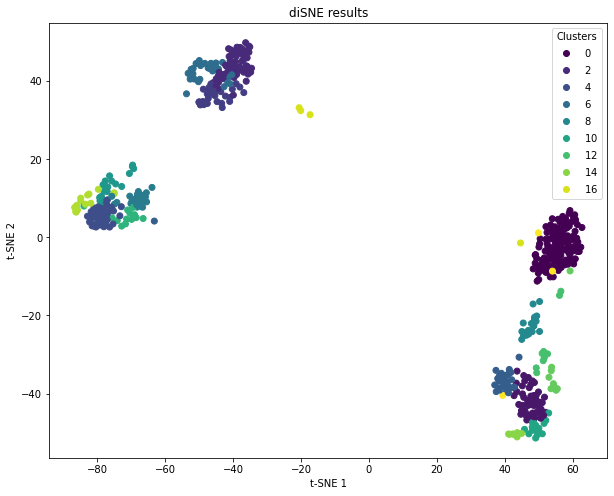

In [63]:
# Extract t-SNE results and cluster labels
tsne_out = adata_var.obsm['X_tsne']
clusters = adata_var.obs['leiden'].astype(int).values  # Cluster labels

# Plot the t-SNE results
plot_tsne_results(adata_var, feature='leiden')
# SUBSET

In [ ]:
# Extract t-SNE results and cluster labels
tsne_out = adata_var.obsm['X_tsne']
clusters = adata_var.obs['leiden'].astype(int).values  # Cluster labels

# Plot the t-SNE results
plot_tsne_results(adata_var, feature='leiden')